In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_curve,
    f1_score, accuracy_score
)

import xgboost as xgb

# ─── Load Data ─────────────────────────────────────────────────────────────
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

test_ids = test_df["Loan_ID"]
train_df.drop("Loan_ID", axis=1, inplace=True)
test_df.drop("Loan_ID", axis=1, inplace=True)

# ─── Feature Engineering ───────────────────────────────────────────────────
for df in [train_df, test_df]:
    df["TotalIncome"] = df["ApplicantIncome"] + df["CoapplicantIncome"]
    df["LoanIncomeRatio"] = df["LoanAmount"] / (df["TotalIncome"] + 1)
    df["IncomeBins"] = pd.qcut(df["TotalIncome"], 4, labels=False)

features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
            'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
            'Credit_History', 'Property_Area', 'TotalIncome', 'LoanIncomeRatio', 'IncomeBins']
target = 'Loan_Status'

X = train_df[features]
y = train_df[target].map({'Y': 1, 'N': 0})
X_test = test_df[features]







In [39]:
# ─── Column Processing ─────────────────────────────────────────────────────
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
                  'Credit_History', 'TotalIncome', 'LoanIncomeRatio', 'IncomeBins']
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])



In [40]:
# ─── Cross-Validation Setup ────────────────────────────────────────────────
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
thresholds = []
f1_scores = []

params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "learning_rate": 0.05,
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
    print(f"\n🔁 Fold {fold}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Preprocessing
    preprocessor.fit(X_train)
    X_train_proc = preprocessor.transform(X_train)
    X_val_proc = preprocessor.transform(X_val)

    dtrain = xgb.DMatrix(X_train_proc, label=y_train)
    dval = xgb.DMatrix(X_val_proc, label=y_val)

    booster = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=[(dtrain, "train"), (dval, "eval")],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    # Predict & Threshold Tuning
    y_val_proba = booster.predict(dval)
    precisions, recalls, thresholds_all = precision_recall_curve(y_val, y_val_proba)
    fbeta_scores = [((1 + 0.5**2) * p * r) / ((0.5**2 * p) + r + 1e-8)
                    for p, r in zip(precisions[:-1], recalls[:-1])]
    best_index = np.argmax(fbeta_scores)
    best_threshold = thresholds_all[best_index]
    thresholds.append(best_threshold)

    y_val_pred = (y_val_proba >= best_threshold).astype(int)
    score = f1_score(y_val, y_val_pred)
    f1_scores.append(score)

    print(f"Best Threshold (Fold {fold}): {best_threshold:.3f}")
    print(f"F1 Score (Fold {fold}): {score:.4f}")
    print(classification_report(y_val, y_val_pred))



🔁 Fold 1
Best Threshold (Fold 1): 0.638
F1 Score (Fold 1): 0.8814
              precision    recall  f1-score   support

           0       0.77      0.63      0.70        38
           1       0.85      0.92      0.88        85

    accuracy                           0.83       123
   macro avg       0.81      0.77      0.79       123
weighted avg       0.83      0.83      0.82       123


🔁 Fold 2
Best Threshold (Fold 2): 0.459
F1 Score (Fold 2): 0.8865
              precision    recall  f1-score   support

           0       0.87      0.53      0.66        38
           1       0.82      0.96      0.89        85

    accuracy                           0.83       123
   macro avg       0.84      0.75      0.77       123
weighted avg       0.84      0.83      0.82       123


🔁 Fold 3
Best Threshold (Fold 3): 0.655
F1 Score (Fold 3): 0.8743
              precision    recall  f1-score   support

           0       0.83      0.51      0.63        39
           1       0.81      0.95   

In [41]:
# ─── CV Summary ────────────────────────────────────────────────────────────
avg_threshold = np.mean(thresholds)
avg_f1 = np.mean(f1_scores)

print("\n✅ Cross-Validation Complete")
print(f"Average Best Threshold: {avg_threshold:.3f}")
print(f"Average F1 Score: {avg_f1:.4f}")


✅ Cross-Validation Complete
Average Best Threshold: 0.564
Average F1 Score: 0.8802


In [42]:
# ─── Final Training on Full Data & Test Prediction ────────────────────────
preprocessor.fit(X)
X_proc_full = preprocessor.transform(X)
X_test_proc = preprocessor.transform(X_test)

dtrain_full = xgb.DMatrix(X_proc_full, label=y)

final_model = xgb.train(
    params,
    dtrain_full,
    num_boost_round=500,
    evals=[(dtrain_full, "train")],
    early_stopping_rounds=20,
    verbose_eval=False
)


In [43]:
# ─── Final Training on Full Data & Test Prediction ────────────────────────
preprocessor.fit(X)
X_proc_full = preprocessor.transform(X)
X_test_proc = preprocessor.transform(X_test)

dtrain_full = xgb.DMatrix(X_proc_full, label=y)

final_model = xgb.train(
    params,
    dtrain_full,
    num_boost_round=500,
    evals=[(dtrain_full, "train")],
    early_stopping_rounds=20,
    verbose_eval=False
)

In [44]:
# Predict on test using avg threshold
y_test_proba = final_model.predict(xgb.DMatrix(X_test_proc))
y_test_pred = (y_test_proba >= avg_threshold).astype(int)

# ─── Prepare Submission ────────────────────────────────────────────────────
submission = pd.DataFrame({
    "Loan_ID": test_ids,
    "Loan_Status": np.where(y_test_pred == 1, 'Y', 'N')
})
submission.to_csv("submission_xgb_cv.csv", index=False)
print("✅ Final submission saved as submission_xgb_cv.csv")

✅ Final submission saved as submission_xgb_cv.csv



🧾 Evaluation on Full Training Set:
Accuracy: 0.9641693811074918

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       192
           1       0.96      0.99      0.97       422

    accuracy                           0.96       614
   macro avg       0.96      0.95      0.96       614
weighted avg       0.96      0.96      0.96       614



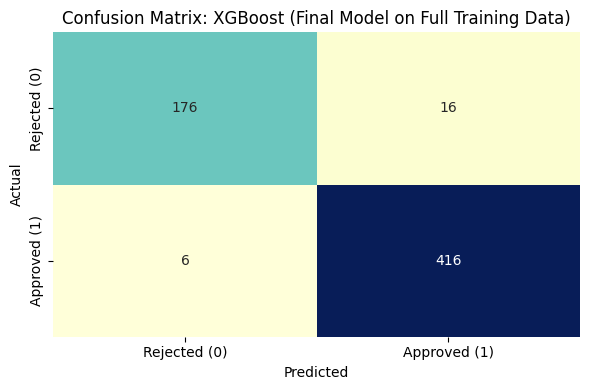

In [45]:
# ─── Confusion Matrix on Training Data ─────────────────────────────────────
y_train_proba = final_model.predict(xgb.DMatrix(X_proc_full))
y_train_pred = (y_train_proba >= avg_threshold).astype(int)

print("\n🧾 Evaluation on Full Training Set:")
print("Accuracy:", accuracy_score(y, y_train_pred))
print("\nClassification Report:")
print(classification_report(y, y_train_pred))

cm = confusion_matrix(y, y_train_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False,
            xticklabels=['Rejected (0)', 'Approved (1)'],
            yticklabels=['Rejected (0)', 'Approved (1)'])
plt.title("Confusion Matrix: XGBoost (Final Model on Full Training Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
